Look at distances

In [1]:
import igraph as ig
import pandas as pd
import numpy as np
import seaborn as sns
from compress_pickle import load, dump
from statistics import mean, median
from c_means_clustering import network_c_means
from copy import deepcopy
import itertools as it
import matplotlib.pyplot as plt
from math import log10

plt.style.use('bmh')

def open_pickle(file):
    with open(path+file, 'rb') as pickle_file:
        return load(path=pickle_file, compression='infer')

path = './files/'

regulome_network_edges = pd.read_csv(filepath_or_buffer=path+'/human_regulome_pd.gz', compression='infer')
regulome_network_edges = regulome_network_edges.astype({'ProteinAid': 'str', 'ProteinBid':'str'})

regulome_graph = ig.Graph.DataFrame(regulome_network_edges, directed=False, use_vids=False)
proteins = pd.concat([regulome_network_edges['ProteinAid'], regulome_network_edges['ProteinBid']]).unique()

clusters_dict = open_pickle("c_means_leiden_clusters.gz")
clusters_dict = {cluster_id: cluster for (cluster_id, cluster) in clusters_dict.items() if len(cluster) > 10}

In [17]:
results_update = network_c_means(regulome_graph, deepcopy(clusters_dict), 2, percentile=99, n_iter=6, optimize=True, distance_measure='edge_ratio', path_lengths=None, cores=6)
    

with open(path+'c_means_6iter_edge_99.gz', 'wb') as file:
    dump(results_update, file, compression='infer')


results_update = open_pickle("c_means_6iter_edge_99.gz")

Iteration 1 of 6


100%|██████████| 15041/15041 [00:37<00:00, 397.91it/s]


Updating Clusters: percentile 99
Iteration 2 of 6


100%|██████████| 15041/15041 [00:39<00:00, 377.07it/s]


Updating Clusters: percentile 99
Iteration 3 of 6


100%|██████████| 15041/15041 [00:39<00:00, 383.44it/s]


Updating Clusters: percentile 99
Iteration 4 of 6


100%|██████████| 15041/15041 [00:40<00:00, 370.72it/s]


Updating Clusters: percentile 99
Iteration 5 of 6


100%|██████████| 15041/15041 [00:41<00:00, 366.67it/s]


Updating Clusters: percentile 99
Iteration 6 of 6


100%|██████████| 15041/15041 [00:35<00:00, 423.77it/s]


Updating Clusters: percentile 99


In [51]:
protein_edges = pd.concat([regulome_network_edges['ProteinAid'], regulome_network_edges['ProteinBid']]).value_counts()
most_connected_proteins = tuple(protein_edges.index[:5])
least_connected_proteins = tuple(protein_edges.index[-5:])

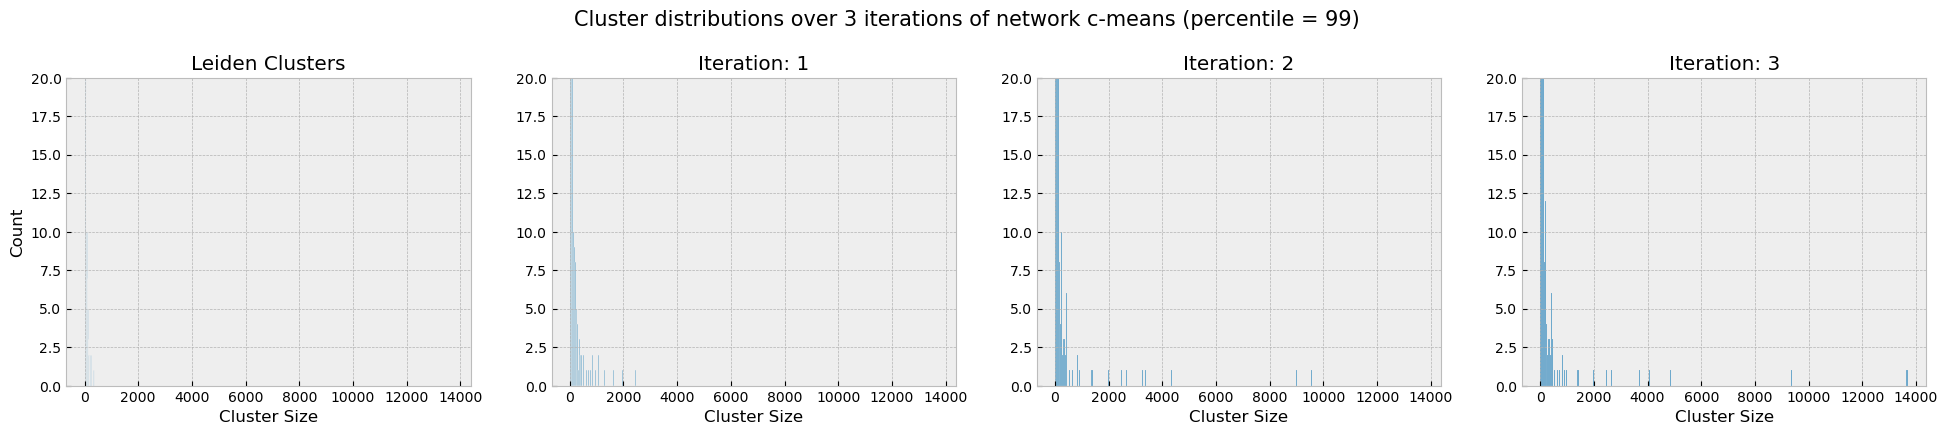

In [20]:
# Distances of least connected
results_update = open_pickle("c_means_6iter_edge_99.gz")
cluster_history = results_update[0][:4]
fig, axes = plt.subplots(1,len(cluster_history),figsize=[24,4], sharex=True)
title = fig.suptitle(f"Cluster distributions over 3 iterations of network c-means (percentile = 99)", fontsize=15, y=1.05)

for iter, (ax, clusters) in enumerate(zip(axes, cluster_history)):
    result_sizes = [len(cluster) for cluster in clusters.values()]
    sns.histplot(result_sizes, ax=ax).set_ylim([0, 20])
    ax.set_title(f"Iteration: {iter}")
    ax.set_xlabel("Cluster Size")
    if iter != 0:
        ax.set(ylabel=None)
    else:
        ax.set_title(f"Leiden Clusters")


plt.savefig('./images/c_means_update_iter_edge_99.png', dpi=fig.dpi, bbox_inches='tight',bbox_extra_artists=[title])


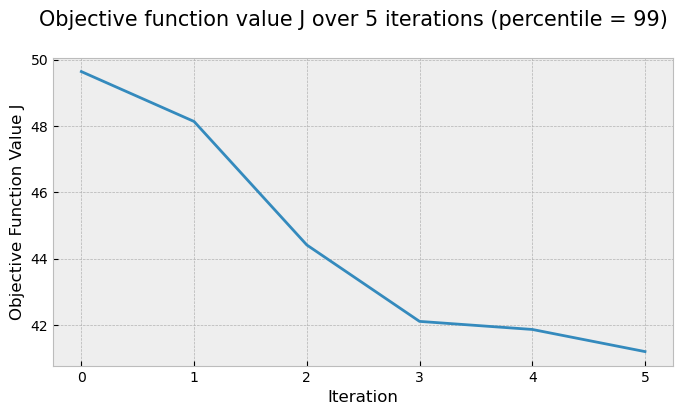

In [27]:
J_values = results_update[1]

fig, ax = plt.subplots(1,1,figsize=[8,4], sharex=True)
title = fig.suptitle(f"Objective function value J over 5 iterations (percentile = 99)", fontsize=15, y=1)

sns.lineplot(J_values, ax=ax)
ax.set_xlabel("Iteration")
ax.set_ylabel("Objective Function Value J")

plt.savefig('./images/c_means_optimization.png', dpi=fig.dpi, bbox_inches='tight',bbox_extra_artists=[title])


292


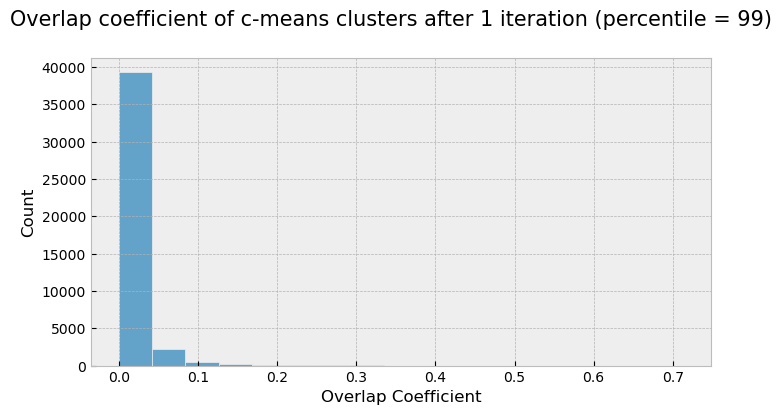

In [72]:
from itertools import combinations

iter1_clusters = results_update[0][3]
clusters = [cluster for cluster in iter1_clusters.values() if len(clusters) if len(cluster) < 2000]
print(len(clusters))

overlap_coefficients = list()

for set_A, set_B in combinations(clusters, 2):
    ov_coeff = (len(set_A.intersection(set_B)))/(min(len(set_A), len(set_B)))
    overlap_coefficients.append(ov_coeff)

fig, ax = plt.subplots(1,1,figsize=[8,4], sharex=True)
title = fig.suptitle(f"Overlap coefficient of c-means clusters after 1 iteration (percentile = 99)", fontsize=15, y=1)

sns.histplot(overlap_coefficients, ax=ax)
ax.set_xlabel("Overlap Coefficient")
# ax.set_ylim([0, 2000])


plt.savefig('./images/c_means_overlap_coeff_edge_99_2.png', dpi=fig.dpi, bbox_inches='tight',bbox_extra_artists=[title])


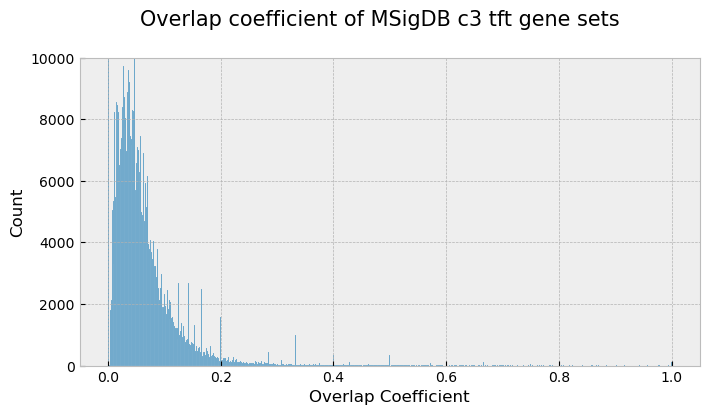

In [60]:
msigdb_c3_tft_dict = open_pickle('msigdb_c3_tft_dict.pkl')
gene_sets = pd.Series([set(gene_set) for gene_set in msigdb_c3_tft_dict.values()])  # some gene sets have no mapping aka have 0 genes
overlap_coefficients = list()

for set_A, set_B in combinations(gene_sets, 2):
    if len(set_A) == 0 or len(set_B) == 0: # tft 3 sets with 0
        continue
    ov_coeff = (len(set_A.intersection(set_B)))/(min(len(set_A), len(set_B)))
    overlap_coefficients.append(ov_coeff)

fig, ax = plt.subplots(1,1,figsize=[8,4], sharex=True)
title = fig.suptitle(f"Overlap coefficient of MSigDB c3 tft gene sets", fontsize=15, y=1)

sns.histplot(overlap_coefficients, ax=ax)
ax.set_xlabel("Overlap Coefficient")
ax.set_ylim([0, 10000])

plt.savefig('./images/c_means_overlap_coeff_tft.png', dpi=fig.dpi, bbox_inches='tight',bbox_extra_artists=[title])